In [1]:
from include.TriggerPrimitive import TriggerPrimitive as TriggerPrimitive
import numpy as np
import matplotlib.pyplot as plt
from include.TPFinder import TPFinder
import os
from scipy.optimize import curve_fit
import random


In [2]:
file_path = '/eos/user/h/hakins/dune/ML/mt_identifier/benchmark/model_70000_on_cut_70000mt_id/prediction_results.txt'
file_path2 = '/eos/user/h/hakins/dune/ML/mt_identifier/benchmark/70000mt_id/prediction_results.txt'

# Open and read the file
with open(file_path, 'r') as file:
    contents = file.read()
with open(file_path2, 'r') as file:
    contents2 = file.read()
# Print the contents
print("Model Trained on 70000 Cut applied on 70000 cut")
print("First Time: ")
print(contents)
print("Second Time: ")
print(contents2)

Model Trained on 70000 Cut applied on 70000 cut
First Time: 
TP, TN, FP, FN
75
462
53
15
605

Second Time: 
TP, TN, FP, FN
80
318
197
10
605



In [3]:

hyperparameters = { #the best.npy file returns the index for a few of them: n_conv_layers, n_dense layers, n_dense_units, n_filters,kernal size
    "n_conv_layers": [1, 2, 3, 4],
    "n_dense_layers": [2, 3, 4],
    "n_filters": [16, 32, 64],
    "kernel_size": [1, 3, 5],
    "n_dense_units": [32, 64, 128],
    "learning_rate": [0.0001, 0.001],
    "decay_rate": [0.9, 0.999]
}
params = np.load(f"/eos/user/h/hakins/dune/ML/mt_identifier/ds-mix-mt-vs-all/80000/hyperopt_simple_cnn/aug_coeff_1/hyperopt_simple_cnn_best.npy", allow_pickle=True)
params_dict = params.item()
print(params)
print(hyperparameters['n_filters'][params_dict['n_filters']])

{'decay_rate': 0.9282621638519386, 'kernel_size': 0, 'learning_rate': 0.0008453576984852961, 'n_conv_layers': 0, 'n_dense_layers': 0, 'n_dense_units': 2, 'n_filters': 2}
64


In [4]:
#New TP finder with added "TPs" (true area...)
def TPFinder(waveform, thresh):

    is_hit = False

    hit_charge =[]    
    this_hit = TriggerPrimitive()
    start_adc = []
    end_adc=[]
    hits = []
    true_adc_areas = []
    

    for tick, adc  in enumerate(waveform):
        
        if (adc > thresh and is_hit==False):
            is_hit = True
            this_hit.time_start =tick
            temp_tick = tick
            start_adc.append(adc)
            while (waveform[temp_tick]>0):
                temp_tick = temp_tick - 1
                
            first_zero = temp_tick
            mean_noise = np.mean(waveform[first_zero-10:first_zero])
            temp_tick = tick
            while (waveform[temp_tick]>mean_noise):
                temp_tick = temp_tick - 1
            true_start = temp_tick
                
                
            
           
        if(is_hit == True):
            hit_charge.append(adc)
           
        if (is_hit and adc<=thresh):
            time_end  = tick
            is_hit = False
            temp_tick_f = tick
            end_adc.append(waveform[tick-1])
           
            for index, ADC in enumerate(hit_charge):
                if (ADC == np.max(hit_charge)):
                    this_hit.adc_peak = ADC
                    this_hit.time_peak = index
            this_hit.adc_integral = np.sum(hit_charge)
            this_hit.time_over_threshold = time_end - this_hit.time_start
            hits.append(this_hit)
            while(waveform[temp_tick]>mean_noise):
                temp_tick_f+=1
            true_end = temp_tick_f
           
            true_adc = 0
            for i in range(true_start,true_end):
                true_adc = true_adc + waveform[i]
            true_adc_areas.append(true_adc)

            #clean up for next hit
            hit_charge = []
            this_hit = TriggerPrimitive()
            
    return hits,true_adc_areas,start_adc,end_adc #return set of hits for waveform
    


In [5]:
labels = {
   
   -1: "multilabel",
    0: "kUnknown",
    1: "kMarley",
    2: "kAr39GenInLAr", 
    3: "kKr85GenInLAr", 
    4: "kAr42GenInLAr", 
    5: "kK42From42ArGenInLAr", 
    6: "kRn222ChainRn222GenInLAr",
    7: "kRn222ChainPo218GenInLAr", 
    8: "kRn222ChainPb214GenInLAr", 
    9: "kRn222ChainBi214GenInLAr",  
    10: "kRn222ChainPb210GenInLAr", 
    11: "kK40GenInCPA",
    12: "kU238ChainGenInCPA",
    13: "kK42From42ArGenInCPA", 
    14: "kRn222ChainPo218GenInCPA",
    15: "kRn222ChainPb214GenInCPA",
    16: "kRn222ChainBi214GenInCPA", 
    17: "kRn222ChainPb210GenInCPA", 
    18: "kRn222ChainFromBi210GenInCPA", 
    19: "kCo60GenInAPA", 
    20: "kU238ChainGenInAPA",
    21: "kRn222ChainGenInPDS",
    22: "kNeutronGenInRock"
    
    }


In [6]:
#load waveform data (100 low energy electron events, 5 - 100 MeV)
#col = np.loadtxt("/eos/home-e/evilla/dune/sn-data/standard/aggregated_prodmarley_nue_spectrum_radiological_decay0_dune10kt_refactored_1x2x6_CC-WFdump-1events_thr30/waveforms_tryWfDumper.txt")
col = np.loadtxt("/eos/user/e/evilla/dune/sn-data/waveforms_withBkg_noNoise_noPedestal.txt")
#col = np.loadtxt("/eos/user/e/evilla/dune/sn-data/customEandD/aggregated_prodmarley_nue_flat_clean_dune10kt_1x2x6_ES_70to70MeV_customDirection-TPdump_standardHF_noiseless_MCtruth-100events_thr30/waveforms_1030.txt")
tps = np.loadtxt("/eos/user/e/evilla/dune/sn-data/customEandD/aggregated_prodmarley_nue_flat_clean_dune10kt_1x2x6_ES_70to70MeV_customDirection-TPdump_standardHF_noiseless_MCtruth-100events_thr30/tpstream_1030.txt")
ind = np.loadtxt("data/PedSubWaveform_Induction_Dump.txt")
event = 1
threshold = 30

In [7]:
count = 0
collection_counter = 0
for data in col:
    if data[2] ==2:
        collection_counter+=1
        ADCS = data[2:]
        hits,true_areas,start_adc,end_adc = TPFinder(ADCS, threshold)
        if hits == []:
            count+=1

print(f'Number of Collection Waveforms: {collection_counter}')
print(f'Number of Collection Waves that breach threshold: {collection_counter-count}')
print(f"Percentage: {((collection_counter-count)/collection_counter)*100}")
 

Number of Collection Waveforms: 1741
Number of Collection Waves that breach threshold: 190
Percentage: 10.913268236645605


In [8]:
#returns recovered area (not including adc_integral)
def recover_area(hit): 
    x1,y1,x2,y2= hit.time_start,threshold,hit.time_peak+hit.time_start,hit.adc_peak 
    slope = (y2-y1)/(x2-x1)
    start_x =(0-y1)/slope + x1
    end_x = x1
    
    x_values = np.linspace(start_x, end_x, 100)
    #y_values = slope * (x_values - x1) + y1
    area_left = (np.abs(start_x-end_x)*threshold)/2  #formula for triangle area

    #Find Equation of Negative Slope Line (Right Side)
    x1,y1,x2,y2= hit.time_start+hit.time_over_threshold-1,threshold,hit.time_peak+hit.time_start,hit.adc_peak 
    slope = (y2-y1)/(x2-x1)
    start_x = x1
    end_x = (0-y1)/slope + x1
    x_values = np.linspace(start_x, end_x, 100)
    #y_values = slope * (x_values - x1) + y1
    area_right = (np.abs(start_x-end_x)*threshold)/2  #formula for triangle area
    
    total_area = area_right+area_left
    return total_area 

In [9]:
collected_tps=[]
for tp in tps:
    adc = tp[4]
    collected_tps.append(adc)


In [10]:
true_labels=[]
#Calculate true area and aprixumated area

recovered_area_list = []
#plot collection waveforms from event
fig1 = plt.figure()
offset = 0
count = 0
adc_integral = []
adc_plus_recovered = []
approximated_error = []
adjusted_approximated_error = []
adjusted_approximated_fraction = []

adc_integral_error = []

adc_real_fraction = []
approximated_real_fraction = []
approximated_fraction = []
recover_over_adc = []
adc_over_recover = []
adc_over_approximate = []
approx_over_true_bkgs = {key: [] for key in labels}
approx_over_true_bkgs_limited = {key: [] for key in labels}

adc_true_fraction = {key: [] for key in labels}
adc_lists = {key: [] for key in labels}
approximated_lists =  {key: [] for key in labels}
adc_integrals = []
true_areas_list=[]
area_lost = []
approximated_areas = []
counter=0
hit_counter = 0
for data in col:
    if data[2] == 2: #collection plane
        counter+=1
        
        pedestal = np.mean(data[3:15])
        pedestal=0
        bkg = data[3]
        true_labels.append(bkg)
        data[2:] = data[2:] - pedestal
        
        ADCS = data[2:]
        hits,true_areas,start_adc,end_adc = TPFinder(ADCS, threshold)
        
        #Should use np arrarys to avoid this many lists - fix
        for i,hit in enumerate(hits):
            hit_counter+=1
            recovered_area = recover_area(hit)
            recovered_area_list.append(recovered_area)
            adc_integral.append(hit.adc_integral)
            adc_integral_error.append(np.abs(hit.adc_integral-true_areas[i])/true_areas[i])
            approximated_area = recovered_area + hit.adc_integral
            approximated_areas.append(approximated_area)
            approximated_real_fraction.append(approximated_area/true_areas[i])
            #Strategy to cut out outliers (cant use true area)
            
            adjusted_approximated_area =  approximated_area
            if (adjusted_approximated_area > hit.adc_integral*2.5) or (hit.adc_integral < 50):
                adjusted_approximated_area = hit.adc_integral/.6
         
            adjusted_approximated_fraction.append(adjusted_approximated_area/true_areas[i])    
            adc_plus_recovered.append(approximated_area)
            approximated_error.append(np.abs(approximated_area-true_areas[i])/true_areas[i])
            adjusted_approximated_error.append(np.abs(adjusted_approximated_area-true_areas[i])/true_areas[i])
            adc_real_fraction.append(hit.adc_integral/true_areas[i])
            
            adc_integrals.append(hit.adc_integral)
            true_areas_list.append(true_areas[i])
            area_lost.append(true_areas[i]-hit.adc_integral)
            
            approximated_fraction.append(approximated_area/true_areas[i])
            recover_over_adc.append(recovered_area/hit.adc_integral)
            adc_over_recover.append(hit.adc_integral/recovered_area)
            adc_over_approximate.append(hit.adc_integral/approximated_area)
            approx_over_true_bkgs[bkg].append(approximated_area/true_areas[i])
            if hit.adc_integral > 750:
                approx_over_true_bkgs_limited[bkg].append(hit.adc_integral/true_areas[i])
            else:
                approx_over_true_bkgs_limited[bkg].append(approximated_area/true_areas[i])
            adc_true_fraction[bkg].append(hit.adc_integral/true_areas[i])
            
            #beta distributions
            adc_lists[bkg].append(hit.adc_integral)
            approximated_lists[bkg].append(approximated_area)

        count+=1


/tmp/hakins/ipykernel_1614835/2486062338.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  slope = (y2-y1)/(x2-x1)
/tmp/hakins/ipykernel_1614835/2486062338.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  slope = (y2-y1)/(x2-x1)
/tmp/hakins/ipykernel_1614835/2492444887.py:74: RuntimeWarning: divide by zero encountered in double_scalars
  adc_over_recover.append(hit.adc_integral/recovered_area)


1741
200


<Figure size 640x480 with 0 Axes>

In [12]:
def calculate_r_squared(y, model):
    y_mean = np.mean(y)
    ss_tot = np.sum((y - y_mean)**2)
    ss_res = np.sum((y - model)**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

/tmp/hakins/ipykernel_1614835/4271691025.py:2: RuntimeWarning: invalid value encountered in log
  return a*np.log(b*x+c)+d


Could not fit


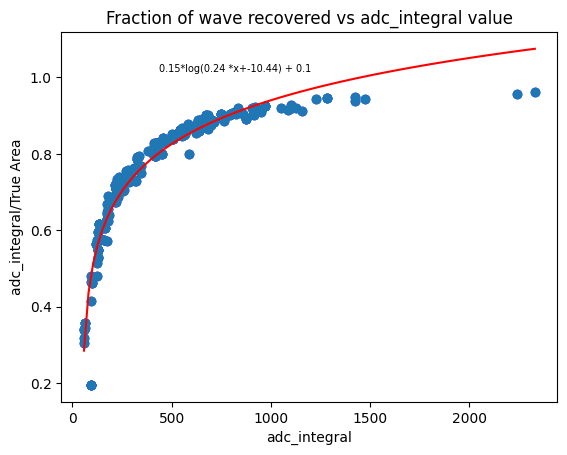

0.9240144310892534


In [13]:
def log(x, a, b,c,d):
    return a*np.log(b*x+c)+d
gueses = 500
initial_guesses_a = [random.uniform(0, 10) for _ in range(gueses)]
initial_guesses_b = [random.uniform(0, 10) for _ in range(gueses)]
initial_guesses_c = [random.uniform(0, 10) for _ in range(gueses)]
initial_guesses_d = [random.uniform(0, 10) for _ in range(gueses)]
best_r2 = -100
best_C_param = 200
best_Q_param = 1
fit_fails = 0
fit_success = 0
best_chi = 0

for i in range(gueses):
    try:
        params, pcov = curve_fit(log, adc_integrals, adc_real_fraction, p0=[initial_guesses_a[i], initial_guesses_b[i], initial_guesses_c[i],initial_guesses_d[i]])
        fit_success+=1
        perr = np.sqrt(np.diag(pcov))
        
        y_pred = []
        for x in adc_integrals:
            y_pred.append(log(x, *params))
        R_squared = calculate_r_squared(np.array(adc_real_fraction), np.array(y_pred))
        #Chi = chisquare(hist_fit, y_pred)
        if R_squared > best_r2:
            best_r2 = R_squared
            best_a_param = params[0]
            best_b_param = params[1]
            best_c_param = params[2]
            best_d_param = params[3]
            best_perr = perr
       
    except RuntimeError as e:
            print(f'Could not fit')
            
plt.scatter(adc_integrals, adc_real_fraction, label='Original data',color='blue')
x_curve = np.linspace(min(adc_integrals), max(adc_integrals), 100)
plt.plot(x_curve, log(x_curve, best_a_param,best_b_param,best_c_param,best_d_param), 'r-', label='Sigmoid Fit')
plt.scatter(adc_integrals, adc_real_fraction, label='Original data')

plt.text(0.35, 0.9, f'{round(params[0],2)}*log({round(params[1],2)} *x+{round(params[2],2)}) + {round(params[3],2)}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=7)
plt.xlabel('adc_integral')
plt.ylabel('adc_integral/True Area')
plt.title('Fraction of wave recovered vs adc_integral value')
plt.show()
print(best_r2)
# Plotting best-fit line in original space

# Adding labels, title, and equation of the line




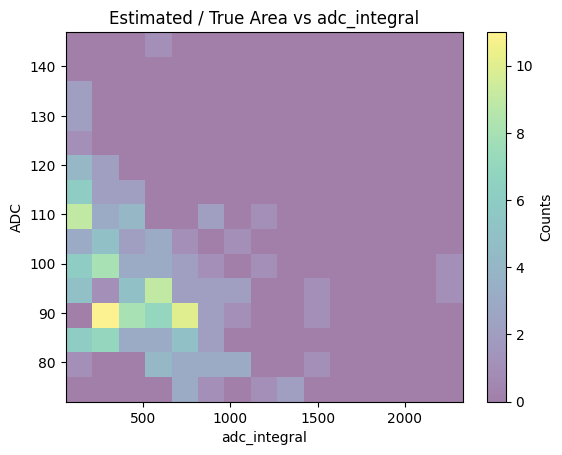

In [14]:
approximated_areas = np.array(approximated_areas)
true_areas_list = np.array(true_areas_list)
#plt.scatter(adc_integrals,approximated_areas/true_areas_list)
adc_int_real = []
real_area_lost = []
for i, x in enumerate(area_lost):
    if x < 200:
        real_area_lost.append(x)
        adc_int_real.append(adc_integrals[i])
        
        
plt.hist2d(adc_int_real, real_area_lost, bins=15, alpha=0.5, cmap='viridis')

# Add color bar
plt.colorbar(label='Counts')

# Add titles and labels
plt.title('Estimated / True Area vs adc_integral')
plt.xlabel('adc_integral')
plt.ylabel('ADC')

# Show plot
plt.show()

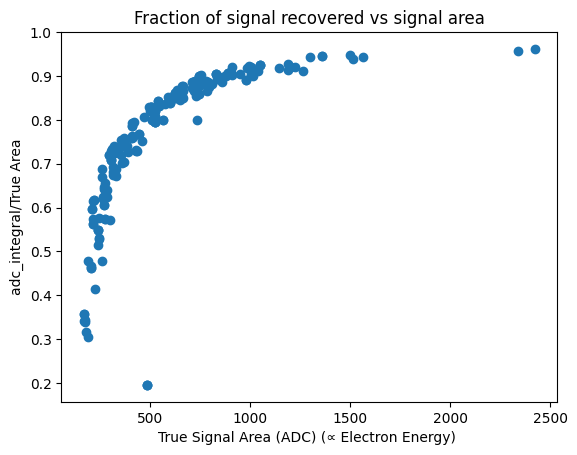

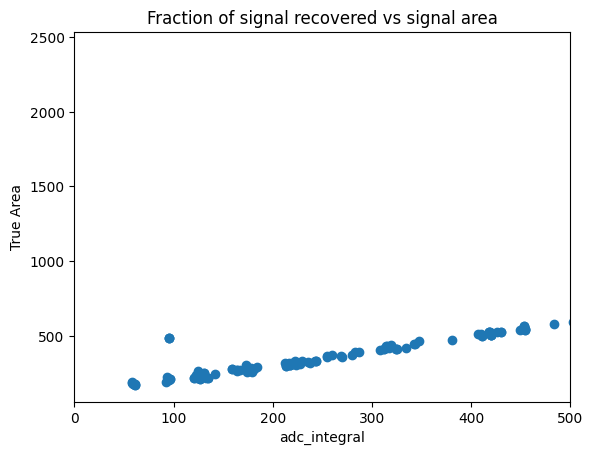

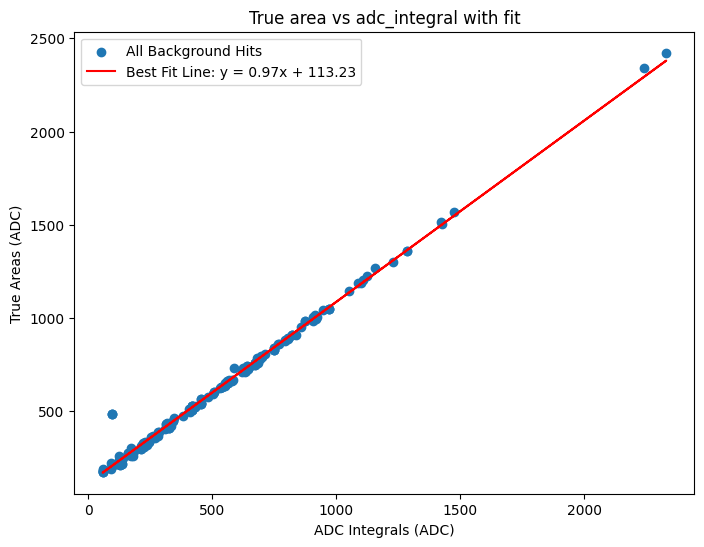

In [15]:

plt.scatter(true_areas_list, adc_real_fraction)

# Adding labels and title
plt.xlabel('True Signal Area (ADC) (∝ Electron Energy) ')
plt.ylabel('adc_integral/True Area')
plt.title('Fraction of signal recovered vs signal area')

# Display the plot
plt.show()
plt.clf()

plt.scatter(adc_integrals, true_areas_list)
plt.xlim(0,500)

# Adding labels and title
plt.xlabel('adc_integral')
plt.ylabel('True Area')
plt.title('Fraction of signal recovered vs signal area')
slope, intercept = np.polyfit(adc_integrals, true_areas_list, 1)
fit_line = slope * np.array(adc_integrals) + intercept

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(adc_integrals, true_areas_list, label='All Background Hits')
plt.plot(adc_integrals, fit_line, color='red', label=f'Best Fit Line: y = {slope:.2f}x + {intercept:.2f}')
plt.xlabel('ADC Integrals (ADC)')
plt.ylabel('True Areas (ADC)')
plt.title('True area vs adc_integral with fit')
plt.legend()

# Display equation of the fitted line



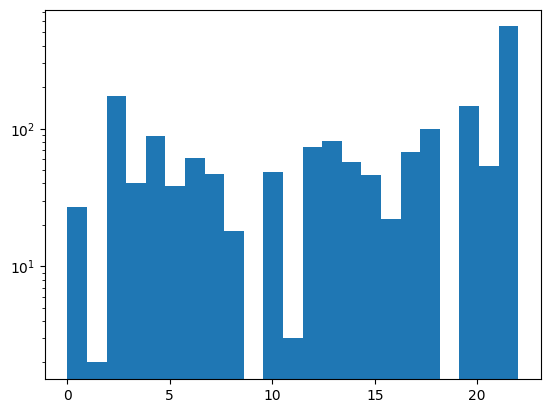

In [16]:
plt.hist(true_labels,bins=23)
plt.yscale('log')




Text(0, 0.5, 'Number of Hits')

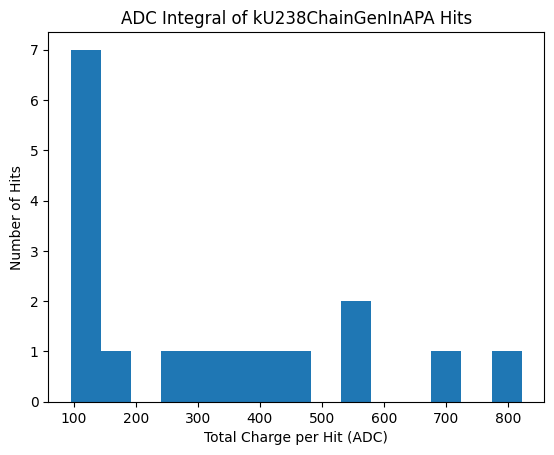

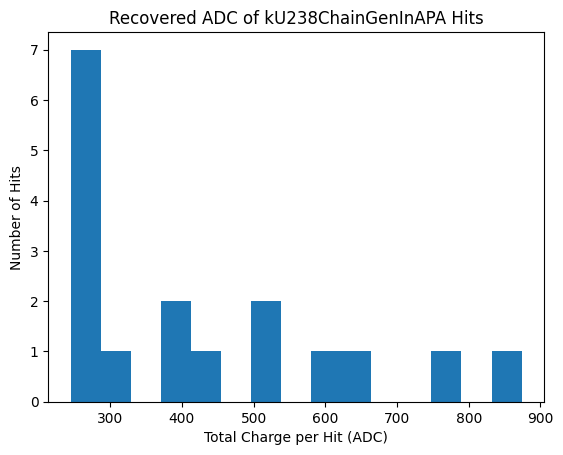

In [17]:
bins=15
plt.hist(adc_lists[20], bins=bins)
plt.title("ADC Integral of kU238ChainGenInAPA Hits")
plt.xlabel("Total Charge per Hit (ADC)")
plt.ylabel("Number of Hits")
fig = plt.figure()
plt.hist(approximated_lists[20],bins=bins)
plt.title("Recovered ADC of kU238ChainGenInAPA Hits")
plt.xlabel("Total Charge per Hit (ADC)")
plt.ylabel("Number of Hits")

24
24


/usr/lib64/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib64/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib64/python3.11/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/lib64/python3.11/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/lib64/python3.11/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


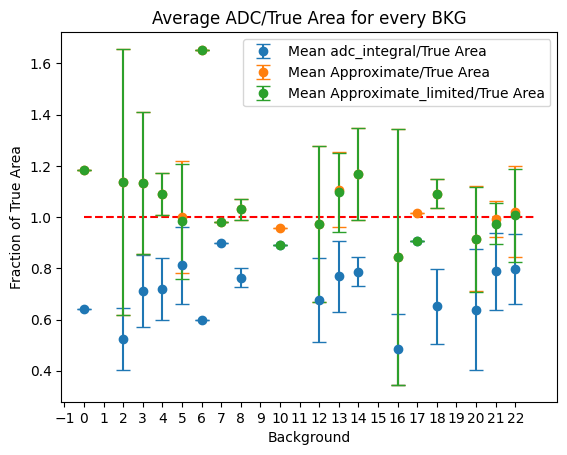

In [18]:
average_adc_true_fractions = []
approx_true_fractions = []
approx_true_fractions_limited = []
stds = []
stds_approx = []
stds_approx_limited = []

for key in adc_true_fraction:
    average_adc_true_fractions.append(np.mean(adc_true_fraction[key]))
    stds.append(np.std(adc_true_fraction[key]))
    approx_true_fractions.append(np.mean(approx_over_true_bkgs[key]))
    stds_approx.append(np.std(approx_over_true_bkgs[key]))
    approx_true_fractions_limited.append(np.mean(approx_over_true_bkgs_limited[key]))
    stds_approx_limited.append(np.std(approx_over_true_bkgs_limited[key]))
    

    
print(len(adc_true_fraction.keys()))
print(len(average_adc_true_fractions))

'''
bin_edges = np.arange(-0.5, 23.5, 1)
plt.hist(true_labels, bins=bin_edges)
plt.yscale('symlog', linthresh=1)'''

plt.errorbar(adc_true_fraction.keys(),average_adc_true_fractions,yerr=stds,capsize=5, fmt="o", label="Mean adc_integral/True Area")
plt.title("Average ADC/True Area for every BKG")
plt.xlabel('Background')
plt.ylabel("Fraction of True Area")
plt.hlines(y=1,xmin=0,xmax=23, linestyles='dashed', colors='red')
plt.xticks(ticks=[-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22])
plt.legend()

plt.errorbar(adc_true_fraction.keys(),approx_true_fractions,yerr=stds_approx,capsize=5, fmt="o", label="Mean Approximate/True Area")
plt.title("Average ADC/True Area for every BKG")
plt.xlabel('Background')
plt.ylabel("Fraction of True Area")
plt.legend()

plt.errorbar(adc_true_fraction.keys(),approx_true_fractions_limited,yerr=stds_approx_limited,capsize=5, fmt="o", label="Mean Approximate_limited/True Area")
plt.title("Average ADC/True Area for every BKG")
plt.xlabel('Background')
plt.ylabel("Fraction of True Area")
plt.legend()



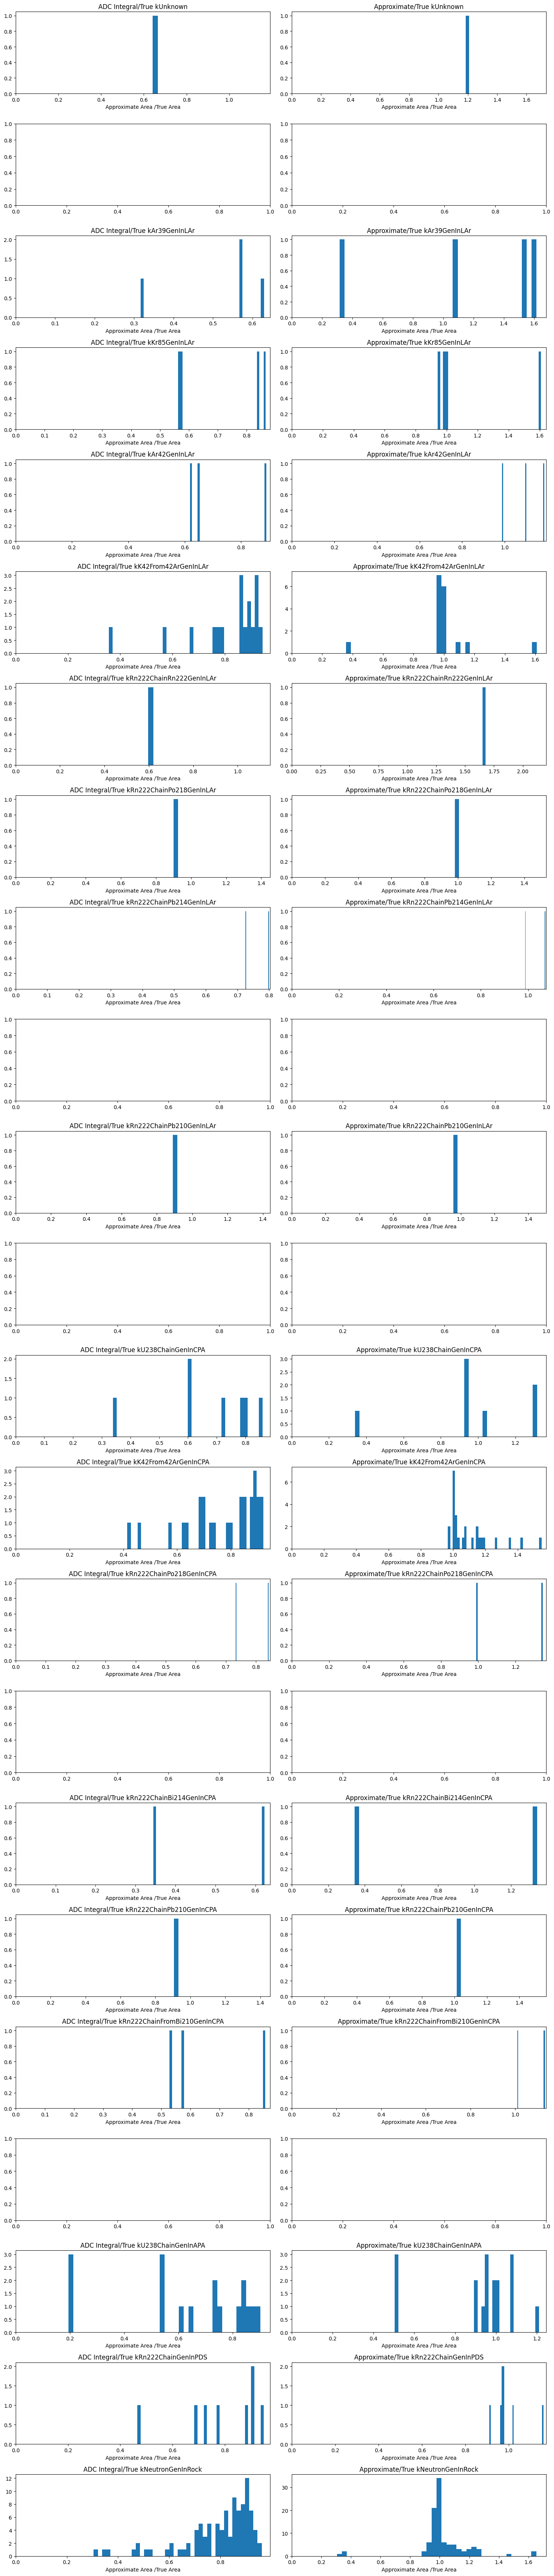

In [19]:
# Number of plots
num_plots = 23

# Create subplots
fig, axes = plt.subplots(num_plots, 2, figsize=(15, num_plots * 3))

# Loop over the range and create the plots

for i in range(num_plots):
    # Plot for adc_true_fraction
    if len(adc_true_fraction[i])>0:
        axes[i, 0].hist(adc_true_fraction[i], bins=40)
        axes[i, 0].set_title(f"ADC Integral/True {labels[i]}")
        axes[i, 0].set_xlabel("Approximate Area /True Area")
        axes[i, 0].set_xlim(left=0)

        # Plot for approx_over_true_bkgs
        axes[i, 1].hist(approx_over_true_bkgs[i], bins=40)
        axes[i, 1].set_title(f"Approximate/True {labels[i]}")
        axes[i, 1].set_xlabel("Approximate Area /True Area")
        axes[i, 1].set_xlim(left=0)

# Adjust layout
plt.tight_layout()
plt.show()

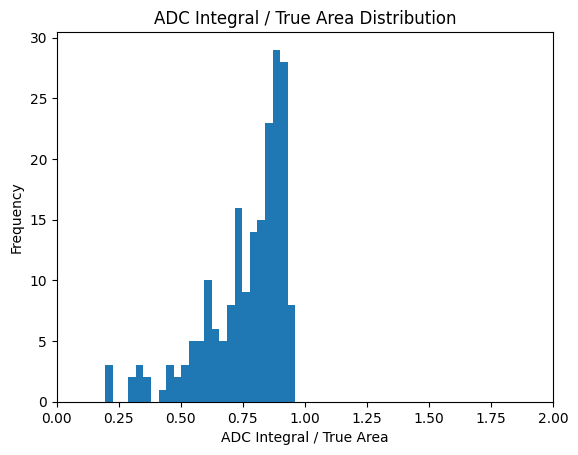

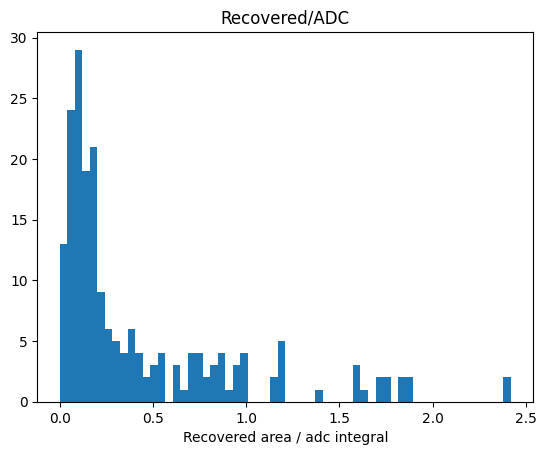

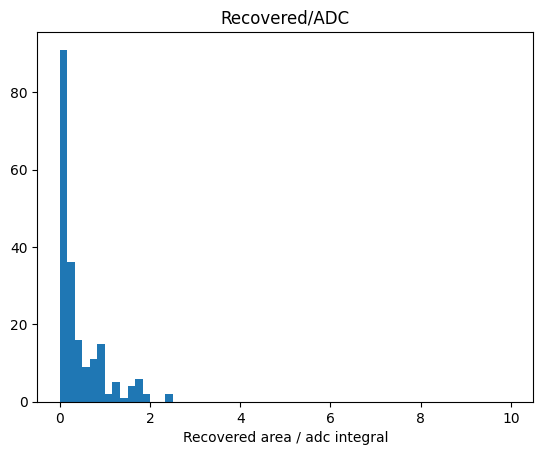

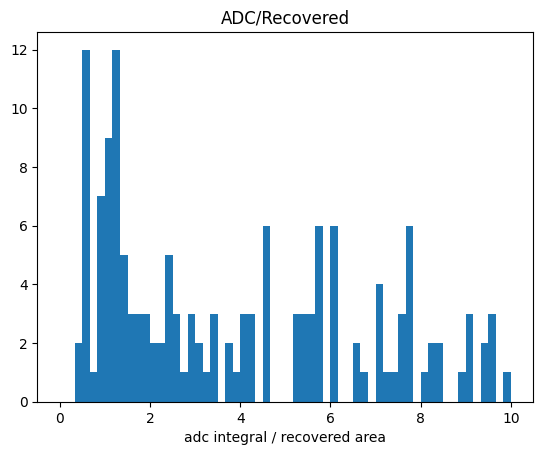

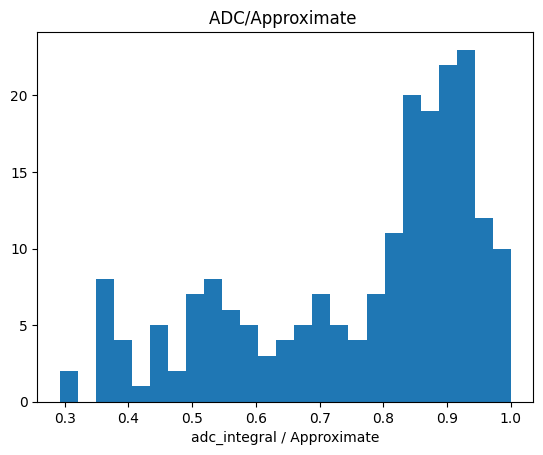

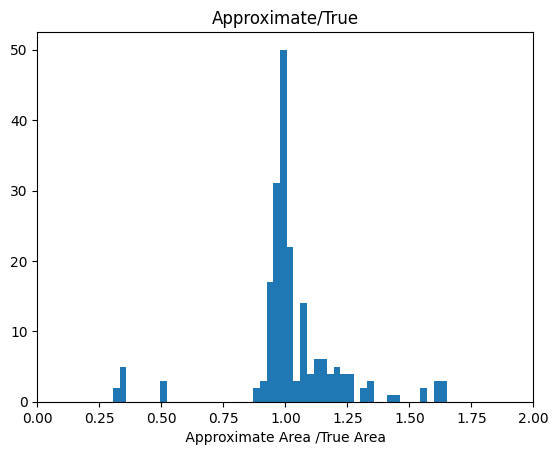

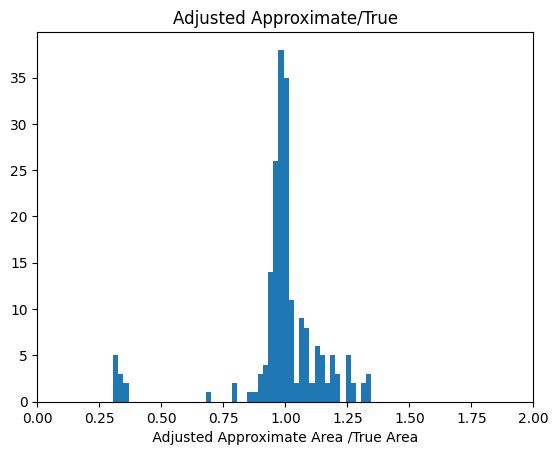

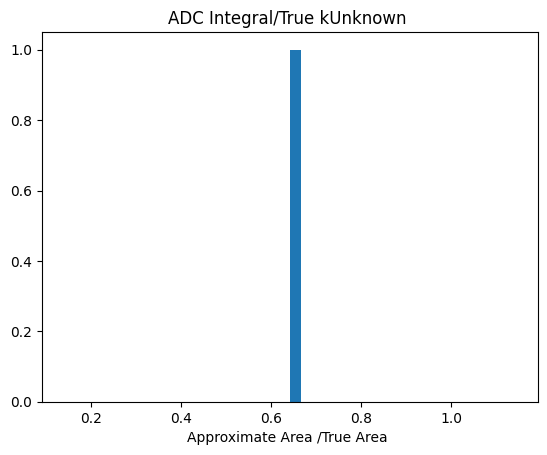

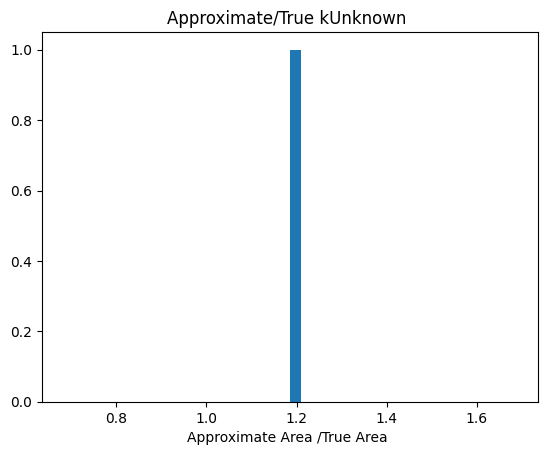

Mean ADC/Real: 0.762418819828641
Median ADC/Real: 0.8206106870229007
Mean Approx/Real: 1.0288172143352812


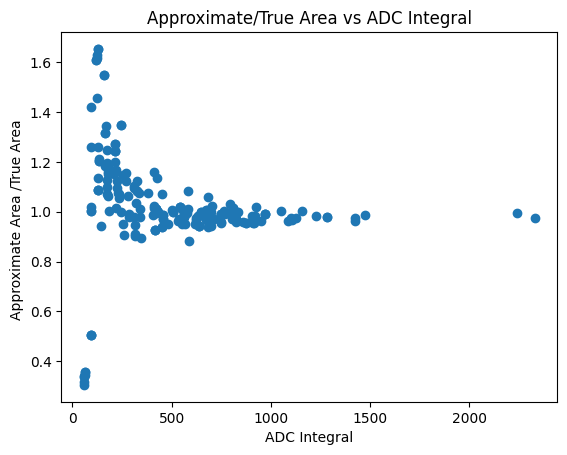

In [28]:
plt.hist(adc_real_fraction,bins=25)
plt.title("ADC Integral / True Area Distribution")
plt.xlabel("ADC Integral / True Area")
plt.xlim(0,2)
plt.ylabel('Frequency')
plt.show()
plt.hist(recover_over_adc,bins=60)
plt.title("Recovered/ADC")
plt.xlabel("Recovered area / adc integral")
plt.show()
plt.hist(recover_over_adc,bins=60, range=(0,10))
plt.title("Recovered/ADC")
plt.xlabel("Recovered area / adc integral")
plt.show()
plt.hist(adc_over_recover,bins=60, range=(0,10))
plt.title("ADC/Recovered")
plt.xlabel("adc integral / recovered area")
plt.show()
plt.hist(adc_over_approximate,bins=25)
plt.title("ADC/Approximate ")
plt.xlabel("adc_integral / Approximate")
plt.show()
plt.hist(approximated_fraction,bins=50)
plt.title("Approximate/True")
plt.xlim(0,2)
plt.xlabel(" Approximate Area /True Area ")
plt.show()
plt.hist(adjusted_approximated_fraction,bins=50)
plt.xlim(0,2)

plt.title("Adjusted Approximate/True")
plt.xlabel(" Adjusted Approximate Area /True Area ")
plt.show()

plt.hist(adc_true_fraction[0],bins=40)
plt.title(f"ADC Integral/True {labels[0]} ")
plt.xlabel("Approximate Area /True Area ")
plt.show()

plt.hist(approx_over_true_bkgs[0],bins=40)
plt.title(f"Approximate/True {labels[0]} ")
plt.xlabel("Approximate Area /True Area ")
plt.show()

plt.scatter(adc_integrals,approximated_real_fraction)
plt.title(f"Approximate/True Area vs ADC Integral")
plt.ylabel("Approximate Area /True Area ")
plt.xlabel("ADC Integral")

print(f"Mean ADC/Real: {np.mean(adc_real_fraction)}")
print(f"Median ADC/Real: {np.median(adc_real_fraction)}")
print(f"Mean Approx/Real: {np.mean(approximated_fraction)}")



Mean ADC_integral Error: 0.23758118017135899
Mean Approx Error: 0.11951575119232687
Mean Adjusted Approx Error: 0.0977827156241819


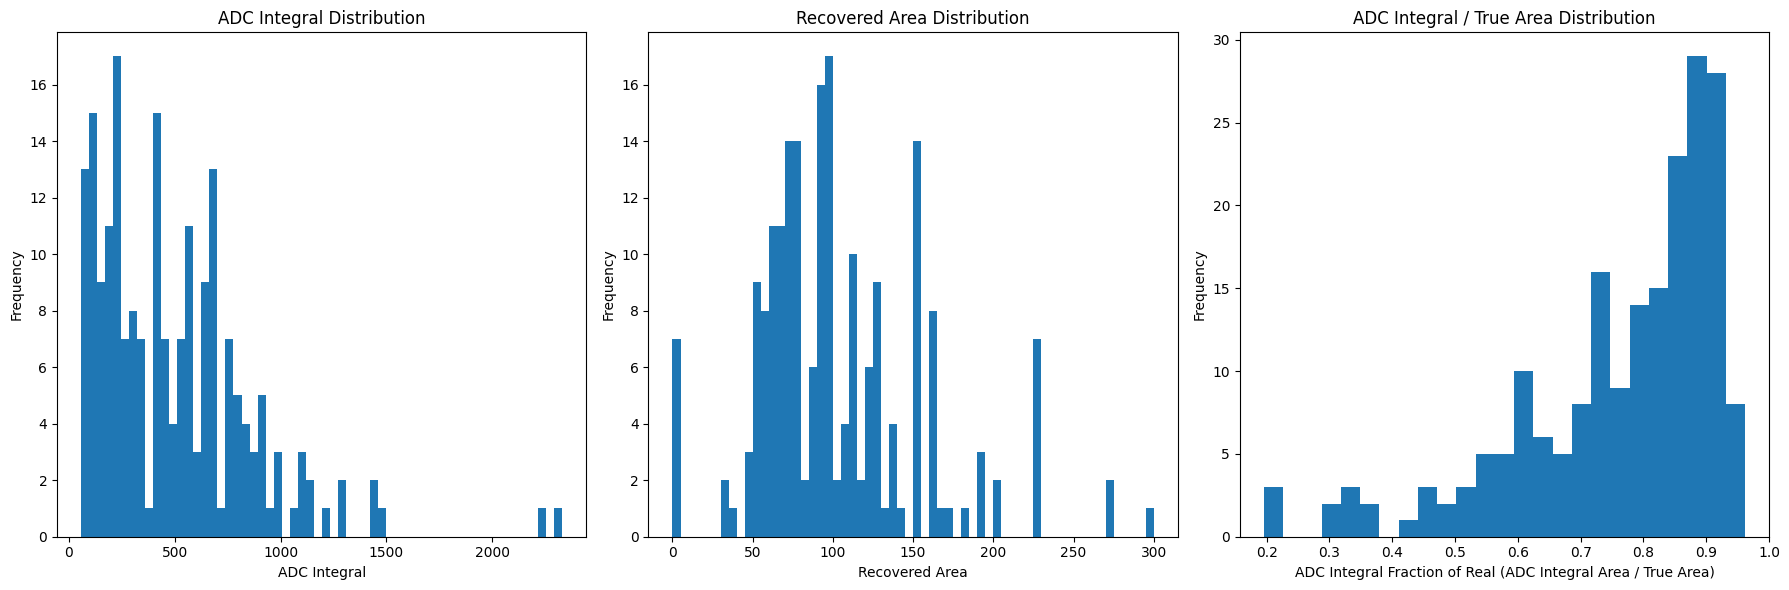

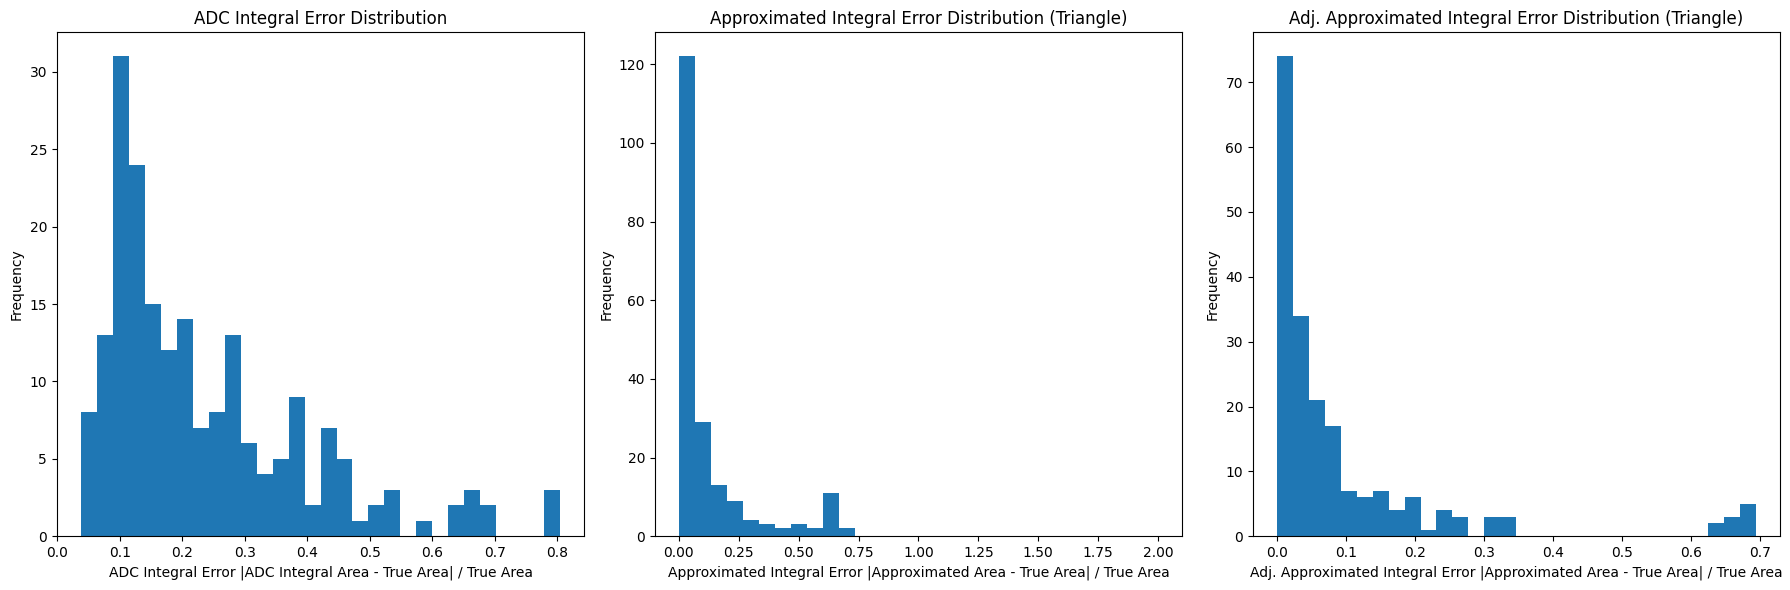

In [21]:


# Print mean errors
print(f"Mean ADC_integral Error: {np.mean(adc_integral_error)}")
print(f"Mean Approx Error: {np.mean(approximated_error)}")
print(f"Mean Adjusted Approx Error: {np.mean(adjusted_approximated_error)}")

# Create the first set of subplots
fig, axs1 = plt.subplots(1, 3, figsize=(18, 6))

# ADC Integral histogram
axs1[0].hist(adc_integral, bins=60)
axs1[0].set_title('ADC Integral Distribution')
axs1[0].set_xlabel('ADC Integral')
axs1[0].set_ylabel('Frequency')

# Recovered Area histogram
axs1[1].hist(recovered_area_list, bins=60)
axs1[1].set_title('Recovered Area Distribution')
axs1[1].set_xlabel('Recovered Area')
axs1[1].set_ylabel('Frequency')

# ADC Integral / True Area histogram
axs1[2].hist(adc_real_fraction, bins=25)
axs1[2].set_title('ADC Integral / True Area Distribution')
axs1[2].set_xlabel('ADC Integral Fraction of Real (ADC Integral Area / True Area)')
axs1[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Create the second set of subplots
fig, axs2 = plt.subplots(1, 3, figsize=(18, 6))

# ADC Integral Error histogram
axs2[0].hist(adc_integral_error, bins=30)
axs2[0].set_title('ADC Integral Error Distribution')
axs2[0].set_xlabel('ADC Integral Error |ADC Integral Area - True Area| / True Area')
axs2[0].set_ylabel('Frequency')

# Approximated Integral Error histogram
axs2[1].hist(approximated_error, bins=30, range=(0,2))
axs2[1].set_title('Approximated Integral Error Distribution (Triangle)')
axs2[1].set_xlabel('Approximated Integral Error |Approximated Area - True Area| / True Area')
axs2[1].set_ylabel('Frequency')

# Adj. Approximated Integral Error histogram
axs2[2].hist(adjusted_approximated_error, bins=30)
axs2[2].set_title('Adj. Approximated Integral Error Distribution (Triangle)')
axs2[2].set_xlabel('Adj. Approximated Integral Error |Approximated Area - True Area| / True Area')
axs2[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [22]:
def plot_dotted_line(x1, y1, x2, y2,y_max,y_min,plot):
    slope = (y2 - y1) / (x2 - x1)
    x_max = (y_max-y1)/slope + x1
    x_min = (y_min-y1)/slope + x1
    x_values = np.linspace(x_min, x_max, 100)
    y_values = slope * (x_values - x1) + y1
    if plot:
        plt.plot(x_values, y_values, 'r--',color='black')
    else:
        return [x_min,x_max,slope]




Plots waveforms with important points. NOTE: adc integral does not exactly start or end at threshold, since the adc value might not land exactly on the threshold since it has a sampling rate limit. The last adc value that is added to adc_integral is the one right before adc < threshold

<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Hit detected
Saved: kK42From42ArGenInCPA/1335_403


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kK42From42ArGenInCPA/1337_404


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Hit detected
Saved: kK42From42ArGenInLAr/4143_408


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kK42From42ArGenInLAr/4056_417


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/741_437


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/1959_461


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/2034_464


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/2039_465


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/2033_470


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kRn222ChainPo218GenInLAr/2033_471


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/2029_472


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/1935_478


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/3373_493


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Hit detected
Saved: kK42From42ArGenInLAr/3502_497


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/2724_508


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kU238ChainGenInCPA/2724_509


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/2724_510


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/883_511


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/2824_522


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/2824_523


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kK42From42ArGenInCPA/2706_534


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kK42From42ArGenInCPA/2706_535


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/2706_536


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kRn222ChainBi214GenInCPA/4279_546


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/2559_566


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/2557_567


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kK42From42ArGenInCPA/4357_568


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kK42From42ArGenInCPA/4358_569


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kK42From42ArGenInLAr/1026_581


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kRn222ChainBi214GenInCPA/2749_920


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kU238ChainGenInCPA/222_930
Hit detected
Saved: kU238ChainGenInCPA/2315_930


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/222_931
Hit detected
Saved: kNeutronGenInRock/2315_931


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kK42From42ArGenInCPA/2638_961


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kKr85GenInLAr/2636_962


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kK42From42ArGenInCPA/2636_963


<Figure size 640x480 with 0 Axes>

Collection
Collection
Hit detected
Saved: kK42From42ArGenInLAr/4120_965


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kK42From42ArGenInLAr/4117_966


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/3177_985


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/2773_994


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/2773_995


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/2773_996


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/1628_1002


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/1628_1003


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kRn222ChainGenInPDS/2493_1052


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kAr42GenInLAr/423_1062


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kK42From42ArGenInCPA/1959_1074


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kK42From42ArGenInCPA/1958_1075


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/125_1080


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/1433_1563


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kU238ChainGenInAPA/570_1575


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/161_1580


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/3576_1620


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/3573_1621


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/4104_1628


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/1640_1638


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/1933_1643


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/1939_1644


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/1939_1645


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/4311_1649


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/4219_1655


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/3481_1671


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/3479_1672


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kRn222ChainPo218GenInCPA/4373_1684


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kK42From42ArGenInCPA/4373_1685


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/3414_1690


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/3423_1693


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/3422_1694


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/3066_1699


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/3490_1700


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/3493_1701


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/3240_1705


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/3240_1706


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/3239_1707
Hit detected
Saved: kNeutronGenInRock/3529_1707


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/3239_1708
Hit detected
Saved: kNeutronGenInRock/3529_1708


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/3239_1709
Hit detected
Saved: kNeutronGenInRock/3529_1709


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/3172_1712


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/3172_1713


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/3172_1714


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kK42From42ArGenInCPA/587_1744


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/587_1745


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kK42From42ArGenInCPA/588_1746


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/1066_1753


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/1053_1754


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/2650_1773


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/2650_1774


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kU238ChainGenInAPA/2650_1775


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/2650_1776


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/105_2045


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/3881_2069


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kK42From42ArGenInCPA/1587_2080


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kAr39GenInLAr/1587_2081


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/411_2093


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/153_2109


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kK42From42ArGenInLAr/1324_2122


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kAr42GenInLAr/1324_2123


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kK42From42ArGenInLAr/1326_2124


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/4156_2490


<Figure size 640x480 with 0 Axes>

Collection
Collection
Hit detected
Saved: kNeutronGenInRock/3887_2492


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/4443_2497


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/3944_2498


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/3944_2499


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/3947_2500


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/3942_2506


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/3942_2507


<Figure size 640x480 with 0 Axes>

Collection
Collection
Hit detected
Saved: kNeutronGenInRock/4193_2509


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/3985_2515


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/4302_2523


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/3871_2527


<Figure size 640x480 with 0 Axes>

Collection
Collection
Hit detected
Saved: kAr39GenInLAr/929_2529


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kK42From42ArGenInCPA/1272_2544


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Hit detected
Saved: kAr39GenInLAr/3736_2547


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kU238ChainGenInAPA/171_2558


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/2199_2578


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kRn222ChainRn222GenInLAr/2199_2579


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/2199_2580


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/2390_2583


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kRn222ChainPb210GenInLAr/2393_2584


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kNeutronGenInRock/2393_2585


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kRn222ChainGenInPDS/1924_2606


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kU238ChainGenInCPA/3250_2613


<Figure size 640x480 with 0 Axes>

Collection
Hit detected
Saved: kU238ChainGenInCPA/3250_2614


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kU238ChainGenInCPA/1671_2628


<Figure size 640x480 with 0 Axes>

Collection
Collection
Hit detected
Saved: kU238ChainGenInCPA/4264_2630


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/842_2916


<Figure size 640x480 with 0 Axes>

Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Collection
Hit detected
Saved: kNeutronGenInRock/1476_2957


<Figure size 640x480 with 0 Axes>

Collection
Hit detected


KeyboardInterrupt: 

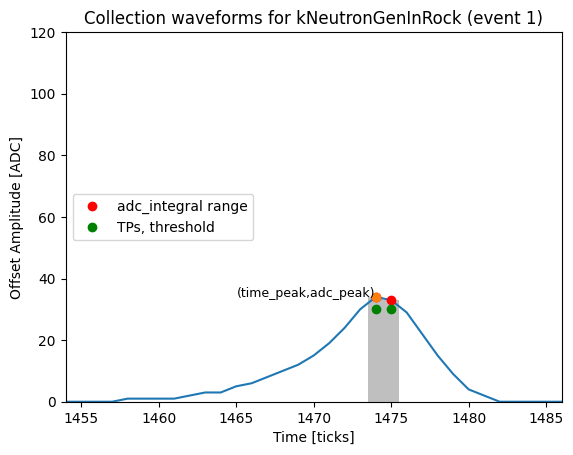

In [25]:
#Plots example wave form with triangle area recovery

event = 1
threshold = 30

#plot collection waveforms from event
fig1 = plt.figure()
offset = 0
count = 0
adc_integral = []
j=0
plot_recovery = True
for j,data in enumerate(col):
    if count > 100000:
        break
    pedestal = np.mean(data[6:15])
    pedestal=0
    background_label = data[3]
    
    
    
    #data[4:] = data[4:] - pedestal
    if (data[2]==2):
        print('Collection')
        ADCS = data[4:] 
        hits,true_areas,start_adc,end_adc = TPFinder(ADCS, threshold) 
        #for tick, adc in enumerate(ADCS):
        #   plt.plot(tick, adc, 'o', color="lightblue", markersize=7)
        for i,hit in enumerate(hits):
            print("Hit detected")
            plt.title(f"Collection waveforms for {labels[background_label]} (event %.0f)" %event)
            plt.plot(ADCS)#offset by channel number
            plt.plot(hit.time_start,start_adc[i] ,'o', color='red')
            plt.plot(hit.time_start+hit.time_peak,hit.adc_peak, 'o')
            plt.plot(hit.time_start+hit.time_over_threshold-1,end_adc[i], 'o',color='red',label="adc_integral range") #minus 1 because you dont include the charge once adc<thresh, see TPfinder
            plt.plot(hit.time_start,threshold,'o',color='green',label="TPs, threshold")
            plt.plot(hit.time_start+hit.time_over_threshold-1,threshold, 'o',color='green')
            plt.ylim(0,120)
            plt.legend(loc='center left')
            
            plt.xlim(hit.time_start - 20, hit.time_start + hit.time_over_threshold + 10)
            

            #vertical dotted lines
            #plt.plot([hit.time_start - 0.5, hit.time_start - 0.5], [0, threshold], 'r--')
            #plt.plot([hit.time_start - 0.5 + hit.time_over_threshold, hit.time_start - 0.5 + hit.time_over_threshold], [0, threshold], 'r--')

            #traingle dotted lines
            # Plotting the dotted lines
            pos_slope_args = [hit.time_start+hit.time_peak, hit.adc_peak, hit.time_start, threshold,hit.adc_peak,0]
            neg_slope_args = [hit.time_start+hit.time_peak, hit.adc_peak, hit.time_start + hit.time_over_threshold-1, threshold,hit.adc_peak,0]
            if plot_recovery:
                plot_dotted_line(pos_slope_args[0],pos_slope_args[1],pos_slope_args[2],pos_slope_args[3],pos_slope_args[4],pos_slope_args[5],True)
                plot_dotted_line(neg_slope_args[0],neg_slope_args[1],neg_slope_args[2],neg_slope_args[3],neg_slope_args[4],neg_slope_args[5],True)
                args = plot_dotted_line(pos_slope_args[0],pos_slope_args[1],pos_slope_args[2],pos_slope_args[3],pos_slope_args[4],pos_slope_args[5],False)
                x_min = args[0]
                x_max = args[1]
                slope = args[2]
                x_values = np.linspace(x_min,hit.time_start,100)
                y_values = slope * (x_values - hit.time_start) + threshold
                plt.fill_between(x_values, y_values, alpha=0.3, color='blue')
                args = plot_dotted_line(neg_slope_args[0],neg_slope_args[1],neg_slope_args[2],neg_slope_args[3],neg_slope_args[4],neg_slope_args[5],False)

                x_min = args[0]
                x_max = args[1]
                slope = args[2]
                x_values = np.linspace(hit.time_start+hit.time_over_threshold-1,x_min,100)
                y_values = slope * (x_values - (hit.time_start+hit.time_over_threshold-1)) + threshold
                plt.fill_between(x_values, y_values, alpha=0.3, color='blue')
            #plt.plot([34,hit.time_start - 0.5], [hit.adc_peak, threshold], 'r--', color='black')
            #plt.plot([34, hit.time_start - 0.5 + hit.time_over_threshold], [hit.adc_peak, threshold], 'r--',color='black')
            
            #adding text
            #plt.text(hit.time_start - 0.5 - 1, threshold, '(time_start, threshold)', fontsize=9, ha='right')
            plt.text(hit.time_start+hit.time_peak, hit.adc_peak, '(time_peak,adc_peak)', fontsize=9, ha='right')
            #plt.text(hit.time_start - 0.5 + hit.time_over_threshold+30, threshold, '(time_start + time_over_threshold, threshold)', fontsize=6.5, ha='right')
            
            #shading adc_integral area
            x_positions = np.arange(len(ADCS))
            start = (hit.time_start)
            end = (hit.time_start + hit.time_over_threshold-1)
            for i in range(start, end + 1):
                plt.bar(i, ADCS[i], color='gray', alpha=.5,width=1)
                
        

            adc_integral.append(hit.adc_integral)
            count+=1
            
            #shading traingle arae
            ''''''


            adc_integral.append(hit.adc_integral)
            count+=1
            plt.ylabel("Offset Amplitude [ADC]")
            plt.xlabel("Time [ticks]")
            os.makedirs(f'/afs/cern.ch/work/h/hakins/private/tp-generator/plots/with_bkg/{labels[background_label]}', exist_ok=True)
            #plt.savefig(f'/afs/cern.ch/work/h/hakins/private/tp-generator/plots/{i}_{j}_signal.png')

            plt.savefig(f'/afs/cern.ch/work/h/hakins/private/tp-generator/plots/with_bkg/{labels[background_label]}/{i}_{j}_signal.png')
            plt.clf()
            print(f'Saved: {labels[background_label]}/{i}_{j}')
    
            
            #plt.text(len(ADCS) + 100, offset, 'channel : %.0f' %data[1])
            offset+=100
            
    plt.show()



#plot induction waveforms for event
for data in col:
    if (background_label==11):
        ADCS = data[2:]
        plt.title("Col waveforms (event %.0f)" %event)
        plt.plot(ADCS + offset)#offset by channel number
        plt.text(len(ADCS) + 100, offset, 'channel : %.0f' %data[1])
        offset+=100
        plt.ylabel("Offset Amplitude [ADC]")
        plt.xlabel("Time [ticks]")
plt.show()
